In [2]:
from torch.utils.data import DataLoader, random_split, WeightedRandomSampler
from torchvision import datasets, transforms, models
from collections import Counter
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from PIL import ImageFile


In [ ]:
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

DATA_DIR = "/kaggle/input/14-classes-dataset/filtered_dataset"
BATCH_SIZE = 32
NUM_CLASSES = 14

Using device: cuda


In [4]:
train_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


In [ ]:
ImageFile.LOAD_TRUNCATED_IMAGES = True

full_dataset = datasets.ImageFolder(root=DATA_DIR, transform=train_transform)

dataset_size = len(full_dataset)
train_size = int(0.8 * dataset_size)
val_size = int(0.1 * dataset_size)
test_size = dataset_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

val_dataset.dataset.transform = val_transform
test_dataset.dataset.transform = val_transform

train_targets = [full_dataset.targets[i] for i in train_dataset.indices]
class_counts = Counter(train_targets)

total_samples = sum(class_counts.values())
class_weights = []
for i in range(len(full_dataset.classes)):
    count = class_counts.get(i, 1)  
    weight = total_samples / (len(class_counts) * count)
    class_weights.append(weight)

class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

# Sampler
sample_weights = [class_weights[label] for label in train_targets]
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
# Model
model = models.resnet50(weights=None) 

model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)

model = model.to(device)


# Loss with class weights
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
# Training loop
EPOCHS = 25
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

        _, preds = torch.max(outputs, 1)
        correct += torch.sum(preds == labels).item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total

    print(f"Epoch {epoch+1}/{EPOCHS} - Loss: {epoch_loss:.4f} - Acc: {epoch_acc:.4f}")

print("✅ Training complete.")

# Save model
torch.save(model.state_dict(), "resnet50_bone_marrow.pth")

Epoch 1/25 - Loss: 1.9255 - Acc: 0.3566
Epoch 2/25 - Loss: 1.3011 - Acc: 0.5654
Epoch 3/25 - Loss: 1.0620 - Acc: 0.6423
Epoch 4/25 - Loss: 0.9244 - Acc: 0.6899
Epoch 5/25 - Loss: 0.7846 - Acc: 0.7376
Epoch 6/25 - Loss: 0.6786 - Acc: 0.7750
Epoch 7/25 - Loss: 0.5874 - Acc: 0.8026
Epoch 8/25 - Loss: 0.4905 - Acc: 0.8386
Epoch 9/25 - Loss: 0.4114 - Acc: 0.8645
Epoch 10/25 - Loss: 0.3434 - Acc: 0.8857
Epoch 11/25 - Loss: 0.2739 - Acc: 0.9098
Epoch 12/25 - Loss: 0.2442 - Acc: 0.9185
Epoch 13/25 - Loss: 0.2037 - Acc: 0.9324
Epoch 14/25 - Loss: 0.1822 - Acc: 0.9403
Epoch 15/25 - Loss: 0.1687 - Acc: 0.9431
Epoch 16/25 - Loss: 0.1595 - Acc: 0.9456
Epoch 17/25 - Loss: 0.1359 - Acc: 0.9536
Epoch 18/25 - Loss: 0.1268 - Acc: 0.9566
Epoch 19/25 - Loss: 0.1119 - Acc: 0.9618
Epoch 20/25 - Loss: 0.1213 - Acc: 0.9582
Epoch 21/25 - Loss: 0.1025 - Acc: 0.9656
Epoch 22/25 - Loss: 0.1086 - Acc: 0.9645
Epoch 23/25 - Loss: 0.0934 - Acc: 0.9680
Epoch 24/25 - Loss: 0.0884 - Acc: 0.9701
Epoch 25/25 - Loss: 0.091

Test Accuracy: 68.36%

Classification Report:
              precision    recall  f1-score   support

         ART       0.65      0.69      0.67       270
         BLA       0.48      0.69      0.57       254
         EBO       0.80      0.82      0.81       267
         EOS       0.88      0.93      0.91       290
         LYT       0.73      0.72      0.73       265
         MMZ       0.58      0.43      0.49       251
         MON       0.69      0.47      0.56       280
         MYB       0.54      0.51      0.53       253
         NGB       0.67      0.59      0.63       281
         NGS       0.74      0.76      0.75       280
         NIF       0.58      0.54      0.56       269
         PEB       0.77      0.89      0.83       270
         PLM       0.74      0.82      0.78       269
         PMO       0.69      0.66      0.67       281

    accuracy                           0.68      3780
   macro avg       0.68      0.68      0.68      3780
weighted avg       0.68      0.68 

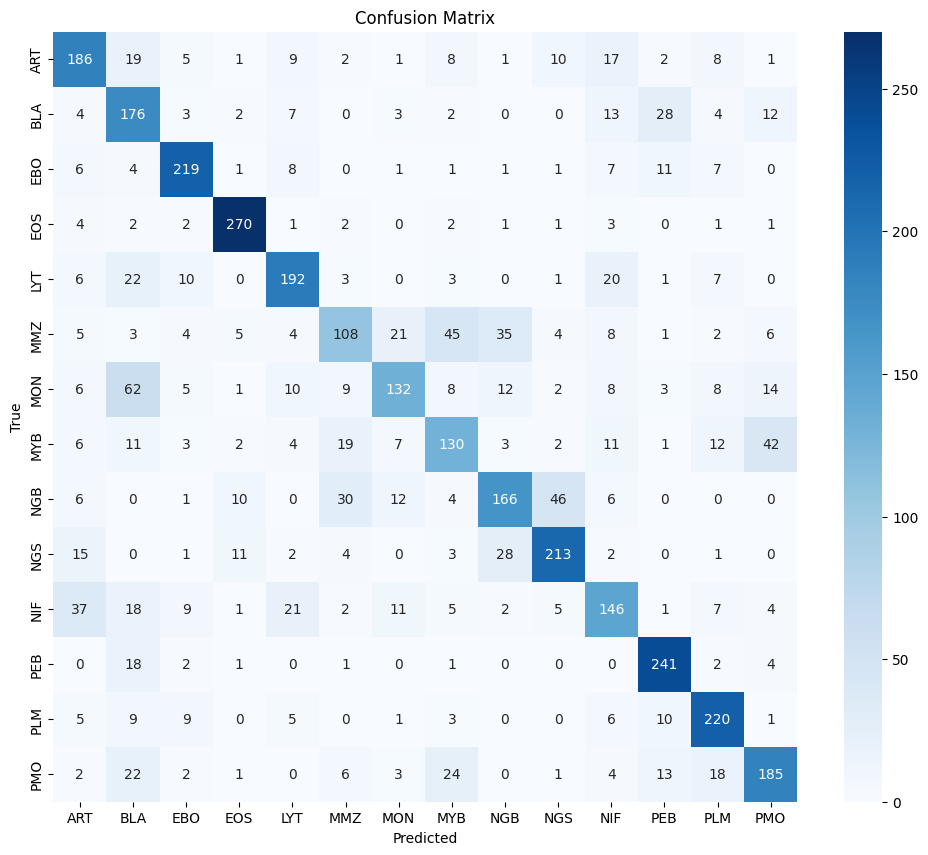

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


# Accuracy
correct = np.sum(np.array(all_preds) == np.array(all_labels))
total = len(all_labels)
accuracy = correct / total

print(f"Test Accuracy: {accuracy*100:.2f}%")


# Per-class metrics
target_names = test_dataset.dataset.classes
 

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=target_names))


# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [9]:
all_preds = []
all_true = []

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images.to(device))
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_true.extend(labels.cpu().numpy())


In [10]:
class_names = test_dataset.dataset.classes
predicted_labels = [class_names[i] for i in all_preds]
true_labels = [class_names[i] for i in all_labels]  


Collected 3780 images.


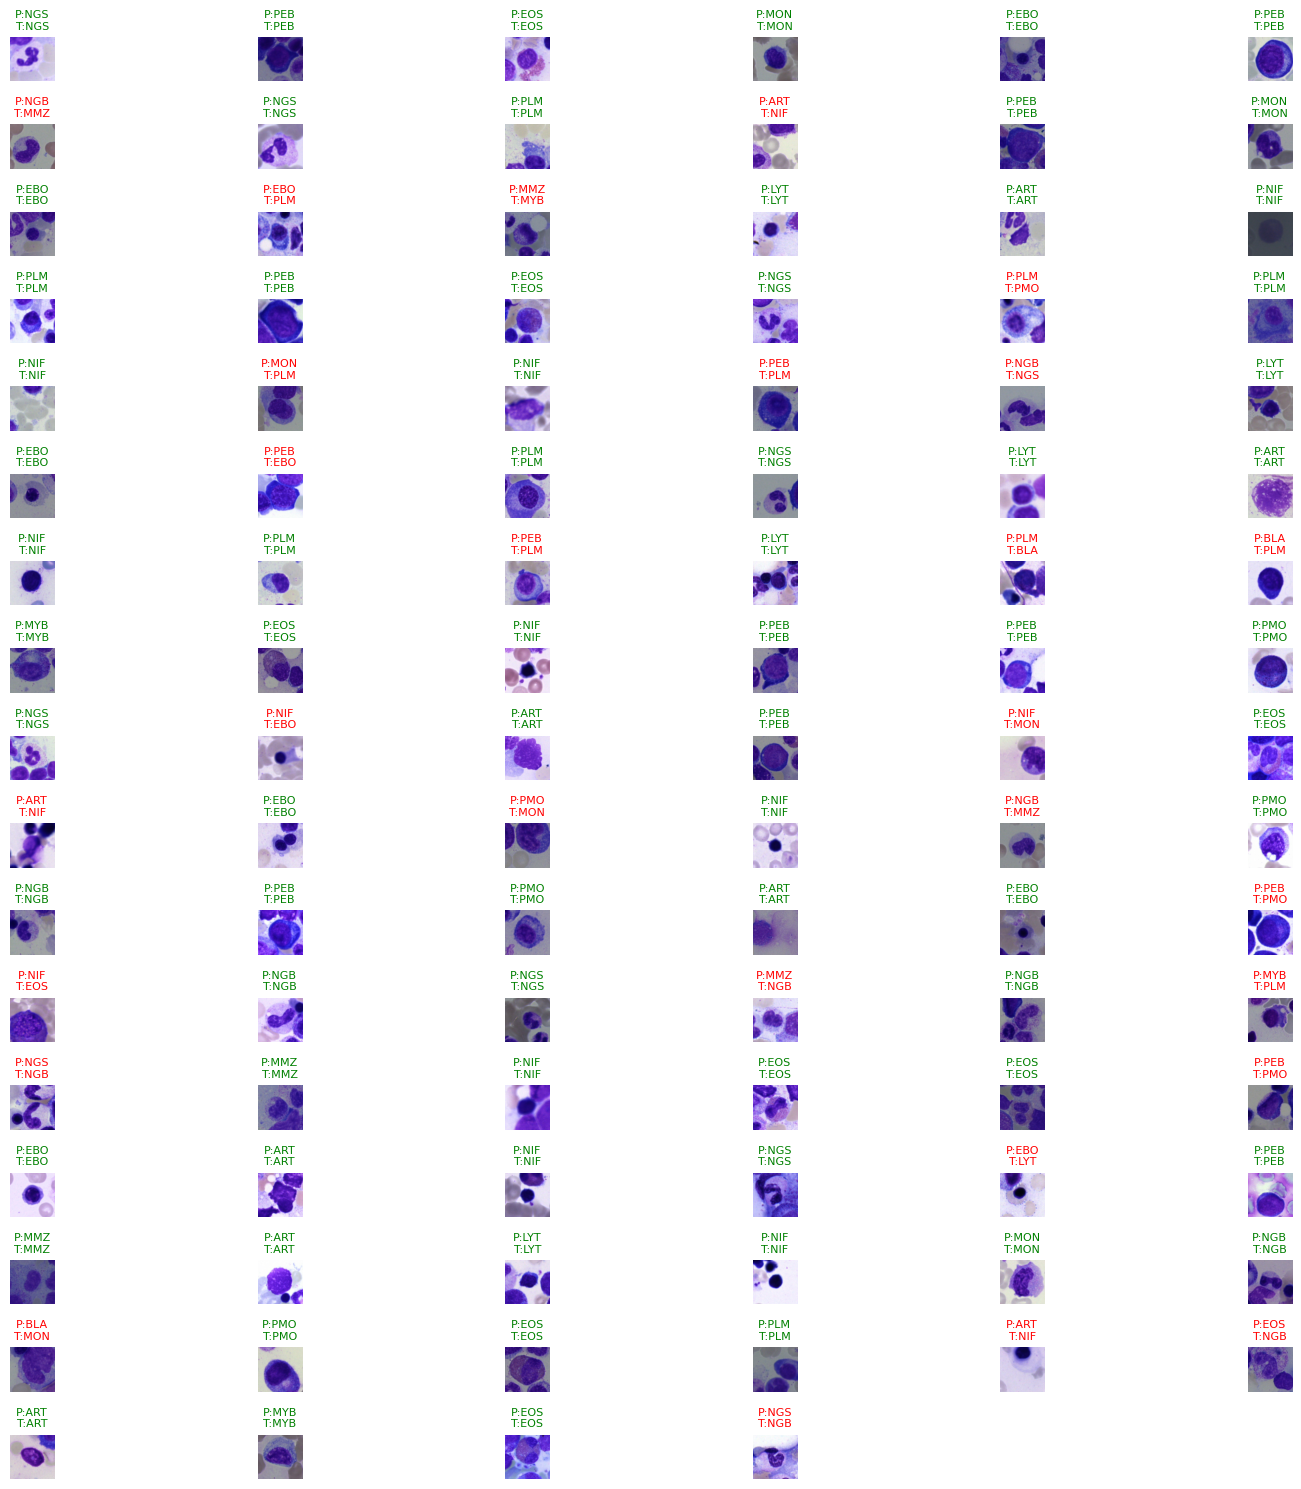

In [ ]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
all_images = []
all_true = []
all_pred = []


with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        
        all_images.append(inputs.cpu())  # store on CPU
        all_true.extend(labels.cpu().numpy())
        all_pred.extend(preds.cpu().numpy())

all_images = torch.cat(all_images, dim=0)  # shape: [N, C, H, W]

print(f"Collected {len(all_images)} images.")

num_to_plot = 100 

plt.figure(figsize=(15, 15))
for i in range(min(num_to_plot, len(all_images))):
    img = all_images[i].permute(1,2,0).numpy()
    img = (img * std + mean)
    img = np.clip(img, 0, 1)
    
    plt.subplot(int(np.ceil(num_to_plot/6)), 6, i+1) 
    plt.imshow(img)
    
    pred_label = test_dataset.dataset.classes[all_pred[i]]
    true_label = test_dataset.dataset.classes[all_true[i]]
    
    color = 'green' if pred_label == true_label else 'red'
    plt.title(f'P:{pred_label}\nT:{true_label}', color=color, fontsize=8)
    plt.axis('off')

plt.tight_layout()
plt.show()
